## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

## **1 - Understanding the data**

In [1]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [2]:
train_data.shape

(84534, 10)

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84534 entries, 0 to 84533
Data columns (total 10 columns):
ID           84534 non-null int64
Promotion    84534 non-null object
purchase     84534 non-null int64
V1           84534 non-null int64
V2           84534 non-null float64
V3           84534 non-null float64
V4           84534 non-null int64
V5           84534 non-null int64
V6           84534 non-null int64
V7           84534 non-null int64
dtypes: float64(2), int64(7), object(1)
memory usage: 6.4+ MB


In [5]:
#Checking if there's any missing values
train_data.isnull().sum()

ID           0
Promotion    0
purchase     0
V1           0
V2           0
V3           0
V4           0
V5           0
V6           0
V7           0
dtype: int64

In [6]:
#Checking the statistics related to numeric variables of the dataframe
train_data.describe()

,ID,purchase,V1,V2,V3,V4,V5,V6,V7
count,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000,84534.000000
mean,62970.972413,0.012303,1.500662,29.973600,0.000190,1.679608,2.327643,2.502898,1.701694
std,36418.440539,0.110234,0.868234,5.010626,1.000485,0.466630,0.841167,1.117349,0.457517
min,1.000000,0.000000,0.000000,7.104007,-1.684550,1.000000,1.000000,1.000000,1.000000
25%,31467.250000,0.000000,1.000000,26.591501,-0.905350,1.000000,2.000000,2.000000,1.000000
50%,62827.500000,0.000000,2.000000,29.979744,-0.039572,2.000000,2.000000,3.000000,2.000000
75%,94438.750000,0.000000,2.000000,33.344593,0.826206,2.000000,3.000000,4.000000,2.000000
max,126184.000000,1.000000,3.000000,50.375913,1.691984,2.000000,4.000000,4.000000,2.000000


## **2 - Checking the invariant metric**

The focus here is to check if the random process of assignment to control and experimental groups is ok (we expect 50/50 split)

In order to check that, we are going to generate a binomial distribution with number of trials of dataset, p and n_trials randoms, analyse times that each sample is greater than the bigger event of success and times that sample is lower than the low event. We set an alpha equals to 0.05 (in case of a p-value higher than 0.05 we keep the null hypothesis)

In [16]:
n_obs = train_data.shape[0]
n_obs

84534

In [17]:
diff_c_t = train_data['Promotion'].value_counts(normalize=True)[0] - train_data['Promotion'].value_counts(normalize=True)[1]
diff_c_t


0.0022949345825348799

In [18]:
train_data['Promotion'].value_counts(normalize=True)[0] / train_data['Promotion'].value_counts(normalize=True)[1]

1.0046004268437279

In [19]:
n_exp = train_data.groupby('Promotion').size()[1]
n_exp

42364

In [20]:
p = 0.5
n = 200000

samples = np.random.binomial(n_obs, p, n)

In [21]:
print("p-value: {}".format(np.logical_or(samples >= n_exp, samples <= (n_obs - n_exp)).mean()))

p-value: 0.50521


**Comment: Since we found a p-value higher than 0.05, we accept that there is no significant difference between the groups**

## **3 - Checking the evaluation metric**

In this process the goal is to check if we have significant statistical difference between the control and experimental group. Is the group that receives the promotion more likely to buy our product? 

We are going to perform a hypothesis test, with a simulation approach 

We also set an aplpha of 0.05

H0: EXP - CTR <= 0
H1: EXP - CTR > 0

In [23]:
#Let's separate the groups from the original dataset (receives or not the promotion)
train_data_ctr = train_data.query("Promotion=='No'")
train_data_ctr.head(8)

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
5,9,No,0,1,41.189415,-0.905350,2,4,4,1
6,11,No,0,1,40.690409,1.085939,2,2,1,2
7,14,No,0,2,25.971529,-1.424817,1,3,3,2
9,16,No,0,1,27.474650,0.566472,2,2,3,2


In [24]:
train_data_exp = train_data.query("Promotion=='Yes'")
train_data_exp.head(8)

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2
8,15,Yes,0,2,31.930423,0.393317,2,3,1,2
10,17,Yes,0,1,32.770916,-1.511395,2,1,4,1
12,20,Yes,0,1,36.957009,0.133583,2,3,1,1
14,22,Yes,0,3,36.911714,-0.905350,2,2,4,1
16,24,Yes,0,1,35.040920,-0.905350,2,4,2,2
18,27,Yes,0,1,35.632751,-0.212728,1,2,4,1
19,28,Yes,0,2,26.328708,1.605406,2,4,2,2


In [25]:
#Register the difference
diff_obs = train_data_exp['purchase'].mean() - train_data_ctr['purchase'].mean()
diff_obs

0.0094545478197727018

In [26]:
train_data_exp['purchase'].mean() / train_data_ctr['purchase'].mean()

2.2498378732282598

In [27]:
#Bootstrap method to resampling
diff=[]

for _ in range(10000):
    samples = train_data.sample(n_obs, replace=True)
    exp = samples.query("Promotion=='Yes'")
    ctr = samples.query("Promotion=='No'")
    pur_exp = exp.purchase.mean()
    pur_ctr = ctr.purchase.mean()
    diff.append(pur_exp - pur_ctr)

(array([  1.00000000e+00,   2.80000000e+01,   2.03000000e+02,
          8.82000000e+02,   2.29700000e+03,   3.03100000e+03,
          2.36400000e+03,   9.69000000e+02,   2.00000000e+02,
          2.50000000e+01]),
 array([ 0.00611979,  0.00672529,  0.00733078,  0.00793628,  0.00854178,
         0.00914727,  0.00975277,  0.01035826,  0.01096376,  0.01156926,
         0.01217475]),
 <a list of 10 Patch objects>)

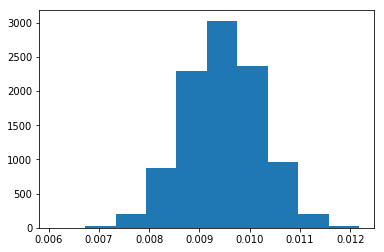

In [28]:
#Checking our difference distribution
diff = np.array(diff)
plt.hist(diff)

In [29]:
#Generating normal distributions with the mean centered at zero and standard deviation equals the one observed in our bootstrap method
null_vals = np.random.normal(0, np.std(diff), 200000)

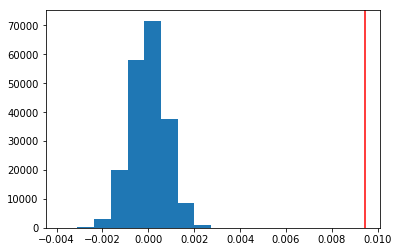

In [30]:
#Checking where our real observed difference is set in our values based in the null hypothesis (generated in the previous process)
plt.hist(null_vals)
plt.axvline(x=diff_obs, color='red')

In [31]:
#Finding the p-value
"p-value: {}".format((null_vals >= diff_obs).mean())

'p-value: 0.0'

**Comment: there is a statistical significance difference between the purchase values observed in each group, treatment and control, since we got a p-value lower than 0.05. That way, we reject the null hypothesis.**

## **4 - Checking the difference in NIR since we confirmed a statistical difference**

In [32]:
nir = (10 * train_data_exp.query("purchase==1").shape[0] - 0.15 * train_data_exp.shape[0]) - 10 * train_data_ctr.query("purchase==1").shape[0]
print("nir: {}".format(nir))

nir: -2334.5999999999995


**Current result: having a negative NIR says to us that although the experiment has a statistical significance, there's no practical significance. It means, we should probably find the same (or better) result in revenue even if we didn'd do any advertising promotions.**

## **5 - EDA**
Let's check our features variables

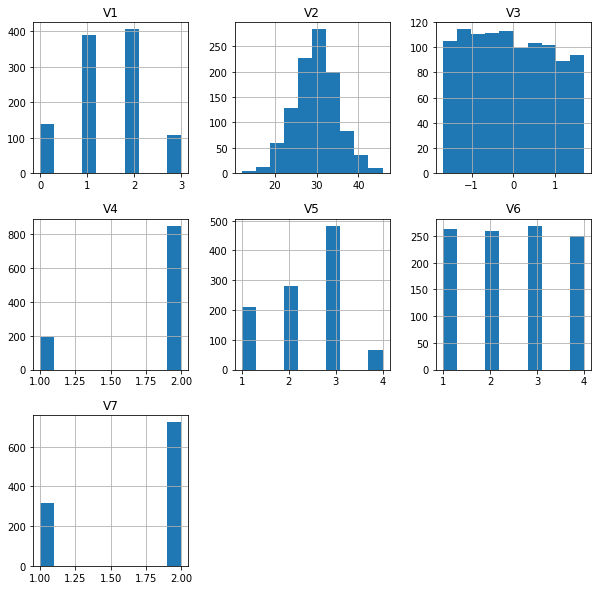

In [33]:
#Ploting the distribution of our features for individuals that bought the product
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']
train_data.query("purchase==1")[features].hist(figsize=(10,10));

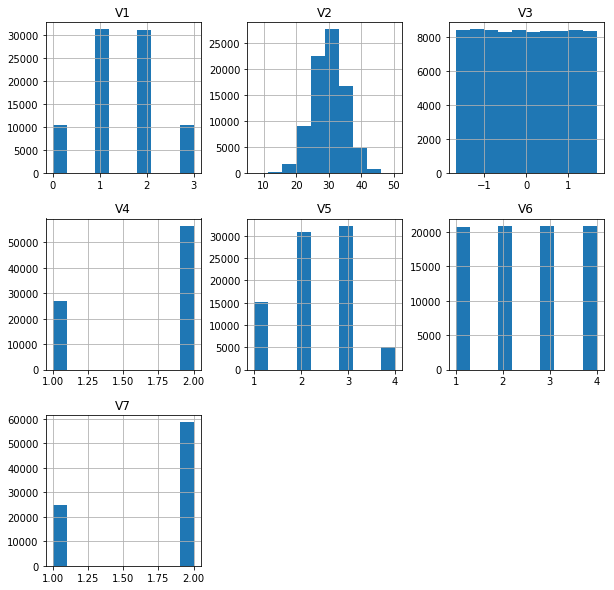

In [34]:
#Ploting the distribution of our features for individuals that did not buy the product
train_data.query("purchase==0")[features].hist(figsize=(10,10));

**Comment: comparing these two scenarios, we do not see a great difference between the group that bought and the group that did not buy**

## **6 - trying to improve our results (create a model to offer a promotion to individuals that has a higher likelyhood of buying the product)**

Let's first check if we have a great difference in any feature between the individuals that buy or not our product

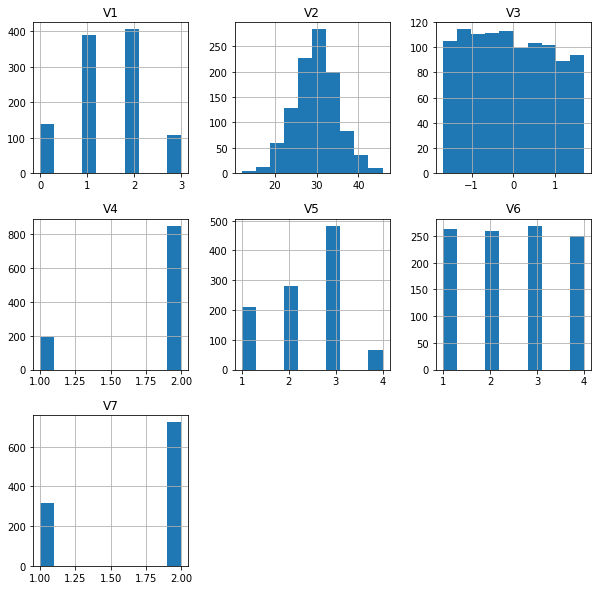

In [35]:
#Ploting the distribution of our features for individuals that bought the product
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']
train_data.query("purchase==1")[features].hist(figsize=(10,10));

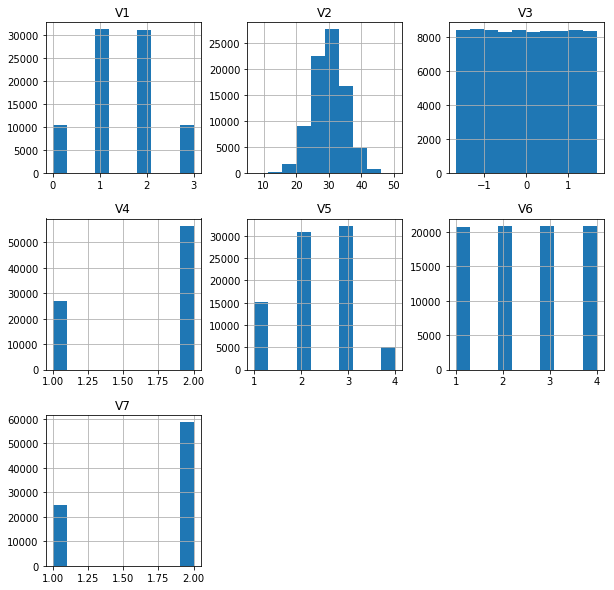

In [36]:
#Ploting the distribution of our features for individuals that did not buy the product
train_data.query("purchase==0")[features].hist(figsize=(10,10));

**Comment: comparing these two scenarios, we do not see a great difference between the group that bought and the group that did not buy**

**Next step is create a model to offer a promotion to individuals that has a higher likelihood of buying the product**

In [38]:
#Dropping the columns that are not our features
train_data_2 = train_data.drop(columns=['ID','purchase','Promotion'], axis=1)
train_data_2.head()

,V1,V2,V3,V4,V5,V6,V7
0,2,30.443518,-1.165083,1,1,3,2
1,3,32.159350,-0.645617,2,3,2,2
2,2,30.431659,0.133583,1,1,4,2
3,0,26.588914,-0.212728,2,1,4,2
4,3,28.044332,-0.385883,1,1,2,2


In [39]:
#Separate the columns with integer as type in order to create dummy variables only for these ones
cols = list(train_data_2.select_dtypes(int).columns)

In [40]:
cols

['V1', 'V4', 'V5', 'V6', 'V7']

In [41]:
#Generating a new dataframe with the dummy variables
train_data_dum = pd.get_dummies(train_data_2, columns=cols, drop_first=True)

In [42]:
train_data_dum.head()

,V2,V3,V1_1,V1_2,V1_3,V4_2,V5_2,V5_3,V5_4,V6_2,V6_3,V6_4,V7_2
0,30.443518,-1.165083,0,1,0,0,0,0,0,0,1,0,1
1,32.159350,-0.645617,0,0,1,1,0,1,0,1,0,0,1
2,30.431659,0.133583,0,1,0,0,0,0,0,0,0,1,1
3,26.588914,-0.212728,0,0,0,1,0,0,0,0,0,1,1
4,28.044332,-0.385883,0,0,1,0,0,0,0,1,0,0,1


In [43]:
#Split into feature and label / train and test
X = train_data_dum
y = train_data['purchase']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [44]:
#Creating a pipeline first for our model, including a standardizing process, and then check for best params using GridSearch 
#process
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', AdaBoostClassifier(DecisionTreeClassifier(random_state=42), random_state=24))
])

params = {
    'clf__base_estimator__class_weight': [None, 'balanced'],
    'clf__base_estimator__max_leaf_nodes': [3, 4],
    'clf__n_estimators': [100, 200],
    'clf__learning_rate': [1, 0.6]
}
    
    
cv = GridSearchCV(pipeline, param_grid=params, scoring='recall', verbose=3)

In [45]:
#Fit the model
cv.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] clf__base_estimator__class_weight=None, clf__base_estimator__max_leaf_nodes=3, clf__learning_rate=1, clf__n_estimators=100 
[CV]  clf__base_estimator__class_weight=None, clf__base_estimator__max_leaf_nodes=3, clf__learning_rate=1, clf__n_estimators=100, score=0.0, total=   5.5s
[CV] clf__base_estimator__class_weight=None, clf__base_estimator__max_leaf_nodes=3, clf__learning_rate=1, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s


[CV]  clf__base_estimator__class_weight=None, clf__base_estimator__max_leaf_nodes=3, clf__learning_rate=1, clf__n_estimators=100, score=0.0, total=   5.2s
[CV] clf__base_estimator__class_weight=None, clf__base_estimator__max_leaf_nodes=3, clf__learning_rate=1, clf__n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.9s remaining:    0.0s


[CV]  clf__base_estimator__class_weight=None, clf__base_estimator__max_leaf_nodes=3, clf__learning_rate=1, clf__n_estimators=100, score=0.0, total=   5.3s
[CV] clf__base_estimator__class_weight=None, clf__base_estimator__max_leaf_nodes=3, clf__learning_rate=1, clf__n_estimators=200 
[CV]  clf__base_estimator__class_weight=None, clf__base_estimator__max_leaf_nodes=3, clf__learning_rate=1, clf__n_estimators=200, score=0.0, total=  10.7s
[CV] clf__base_estimator__class_weight=None, clf__base_estimator__max_leaf_nodes=3, clf__learning_rate=1, clf__n_estimators=200 
[CV]  clf__base_estimator__class_weight=None, clf__base_estimator__max_leaf_nodes=3, clf__learning_rate=1, clf__n_estimators=200, score=0.0, total=  10.4s
[CV] clf__base_estimator__class_weight=None, clf__base_estimator__max_leaf_nodes=3, clf__learning_rate=1, clf__n_estimators=200 
[CV]  clf__base_estimator__class_weight=None, clf__base_estimator__max_leaf_nodes=3, clf__learning_rate=1, clf__n_estimators=200, score=0.0, total= 

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  7.9min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impuri...e=42,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=24))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__base_estimator__class_weight': [None, 'balanced'], 'clf__base_estimator__max_leaf_nodes': [3, 4], 'clf__n_estimators': [100, 200], 'clf__learning_rate': [1, 0.6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=3)

In [46]:
#Checking the best params
cv.best_params_

{'clf__base_estimator__class_weight': 'balanced',
 'clf__base_estimator__max_leaf_nodes': 3,
 'clf__learning_rate': 0.6,
 'clf__n_estimators': 100}

In [47]:
#Predict in the test data
y_pred = cv.predict(X_test)

(array([ 0.5,  1.5]), <a list of 2 Text yticklabel objects>)

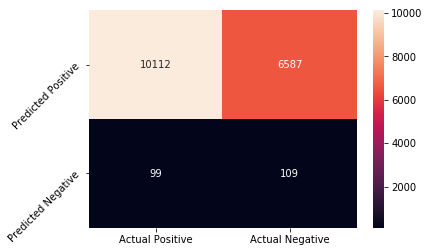

In [48]:
#Confusion matrix to evaluate our model
y_true = y_test
y_pred = y_pred
data = confusion_matrix(y_true, y_pred)


ax=sns.heatmap(data, annot=True, fmt='n')
ax.set_xticklabels(['Actual Positive', 'Actual Negative']) 
ax.set_yticklabels(['Predicted Positive','Predicted Negative'])
plt.yticks(rotation=45)

In [49]:
#Classification report 
def display_result (y_test, y_pred):
    #labels = list(y_test.unique())
    cl_report = classification_report(y_test, y_pred)
    
    print("Classification Report:\n", cl_report)

In [50]:
display_result(y_test, y_pred)

Classification Report:
              precision    recall  f1-score   support

          0       0.99      0.61      0.75     16699
          1       0.02      0.52      0.03       208

avg / total       0.98      0.60      0.74     16907



**Comment: the metric used to evaluate our model, since we have an imbalanced data, was recall. After training the model, we got a recall equals to 0.52 in the class with less quantity.**

In [51]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    X = df
    cols = list(X.select_dtypes(int).columns)
    X_dum = pd.get_dummies(X, columns=cols, drop_first=True)
    y_pred = cv.predict(X_dum)

    promotion = []
    for pred in y_pred:
        if pred == 1:
            promotion.append('Yes')
        else:
            promotion.append('No')
    
    promotion = np.array(promotion)
    
    
    return promotion

In [52]:
# This will test the results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0179.

Your nir with this strategy is 228.05.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.017942849521412403, 228.04999999999995)